In [1]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image
import pandas as pd 
from torch import nn
import torch.nn.functional as F
from math import sqrt
import torchvision
import torchvision.transforms as tt
import random
import matplotlib.pyplot as plt
import torch.utils.data

In [2]:
DATA_DIR = 'root'
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [3]:
train_ds = torchvision.datasets.ImageFolder(DATA_DIR, transform=tt.Compose([
    tt.Resize(image_size),
    tt.CenterCrop(image_size),
    tt.ToTensor(),
    tt.Normalize(*stats)]))

In [4]:
train_ds[0][0].shape

torch.Size([3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


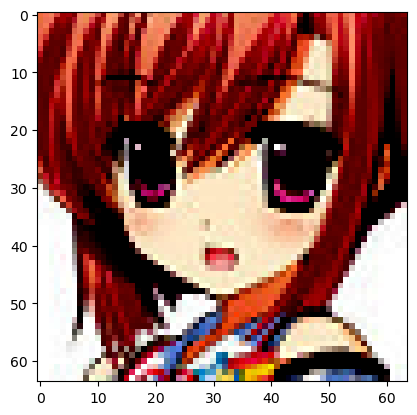

In [5]:
plt.imshow(train_ds[0][0].permute(1,2,0).numpy());

In [6]:
subset_size = int(0.2 * len(train_ds))
subset_indices = torch.randperm(len(train_ds))[:subset_size]
sampler = torch.utils.data.SubsetRandomSampler(subset_indices)

In [7]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size, pin_memory=True, sampler=sampler)

# Genetor and discriminator from the lecture

In [8]:
class Generator(nn.Module):
    def __init__(self, g_input_dim, g_output_dim):
        super(Generator, self).__init__()       
        self.fc1 = nn.Linear(g_input_dim, 256)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features*2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features*2)
        self.fc4 = nn.Linear(self.fc3.out_features, g_output_dim)
    
    # forward method
    def forward(self, x): 
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        return torch.tanh(self.fc4(x))
    
class Discriminator(nn.Module):
    def __init__(self, d_input_dim):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(d_input_dim, 1024)
        self.fc2 = nn.Linear(self.fc1.out_features, self.fc1.out_features//2)
        self.fc3 = nn.Linear(self.fc2.out_features, self.fc2.out_features//2)
        self.fc4 = nn.Linear(self.fc3.out_features, 1)
    
    # forward method
    def forward(self, x):
        x = torch.nn.functional.leaky_relu(self.fc1(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc2(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        x = torch.nn.functional.leaky_relu(self.fc3(x), 0.2)
        x = torch.nn.functional.dropout(x, 0.3)
        return torch.sigmoid(self.fc4(x))
    


In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
#добавим z_dim по сравнению со 100 с лекции, поскольку там были картинки меньше и с 1 каналом. 
#Возможно тут требуется большая размерность, ведь картинки гораздо сложнее
z_dim = 500
anime_dim = 3 * image_size * image_size

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(device)
D = Discriminator(anime_dim).to(device)

In [11]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [12]:
def G_train(x):
    #=======================Train the generator=======================#
    G.zero_grad()

    z = torch.autograd.Variable(torch.randn(batch_size, z_dim).to(device))
    y = torch.autograd.Variable(torch.ones(batch_size, 1).to(device))

    G_output = G(z)
    D_output = D(G_output)
    G_loss = criterion(D_output, y)

    # gradient backprop & optimize ONLY G's parameters
    G_loss.backward()
    G_optimizer.step()
        
    return G_loss.data.item()

In [13]:
def D_train(x):
    #=======================Train the discriminator=======================#
    D.zero_grad()

    # train discriminator on real
    x_real, y_real = x.view(-1, anime_dim), torch.ones(batch_size, 1)
    x_real, y_real = torch.autograd.Variable(x_real.to(device)), torch.autograd.Variable(y_real.to(device))

    D_output = D(x_real)
    D_real_loss = criterion(D_output, y_real)
    D_real_score = D_output

    # train discriminator on facke
    z = torch.autograd.Variable(torch.randn(batch_size, z_dim).to(device))
    x_fake, y_fake = G(z), torch.autograd.Variable(torch.zeros(batch_size, 1).to(device))

    D_output = D(x_fake)
    D_fake_loss = criterion(D_output, y_fake)
    D_fake_score = D_output

    # gradient backprop & optimize ONLY D's parameters
    D_loss = D_real_loss + D_fake_loss
    D_loss.backward()
    D_optimizer.step()
        
    return  D_loss.data.item()

In [14]:
n_epoch = 50
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_dl):
        if len(x) != batch_size:
            continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/50]: loss_d: 0.801, loss_g: 1.209
[2/50]: loss_d: 0.595, loss_g: 1.554
[3/50]: loss_d: 0.565, loss_g: 1.555
[4/50]: loss_d: 0.661, loss_g: 1.900
[5/50]: loss_d: 0.431, loss_g: 7.787
[6/50]: loss_d: 0.243, loss_g: 7.808
[7/50]: loss_d: 0.451, loss_g: 3.085
[8/50]: loss_d: 0.609, loss_g: 3.507
[9/50]: loss_d: 0.701, loss_g: 2.679
[10/50]: loss_d: 0.400, loss_g: 4.309
[11/50]: loss_d: 0.607, loss_g: 4.178
[12/50]: loss_d: 0.587, loss_g: 3.075
[13/50]: loss_d: 0.643, loss_g: 4.528
[14/50]: loss_d: 0.862, loss_g: 2.841
[15/50]: loss_d: 1.035, loss_g: 2.216
[16/50]: loss_d: 1.004, loss_g: 1.834
[17/50]: loss_d: 0.425, loss_g: 2.558
[18/50]: loss_d: 0.935, loss_g: 2.425
[19/50]: loss_d: 1.049, loss_g: 1.887
[20/50]: loss_d: 0.833, loss_g: 2.618
[21/50]: loss_d: 0.953, loss_g: 1.720
[22/50]: loss_d: 0.738, loss_g: 2.677
[23/50]: loss_d: 0.949, loss_g: 2.840
[24/50]: loss_d: 0.606, loss_g: 2.856
[25/50]: loss_d: 0.863, loss_g: 2.552
[26/50]: loss_d: 0.666, loss_g: 2.678
[27/50]: loss_d: 0.42

In [17]:
test_z = torch.autograd.Variable(torch.randn(10, z_dim).to(device))
generated = G(test_z)

In [18]:
generated = generated.view(10, 3, 64, 64)
generated.shape

torch.Size([10, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

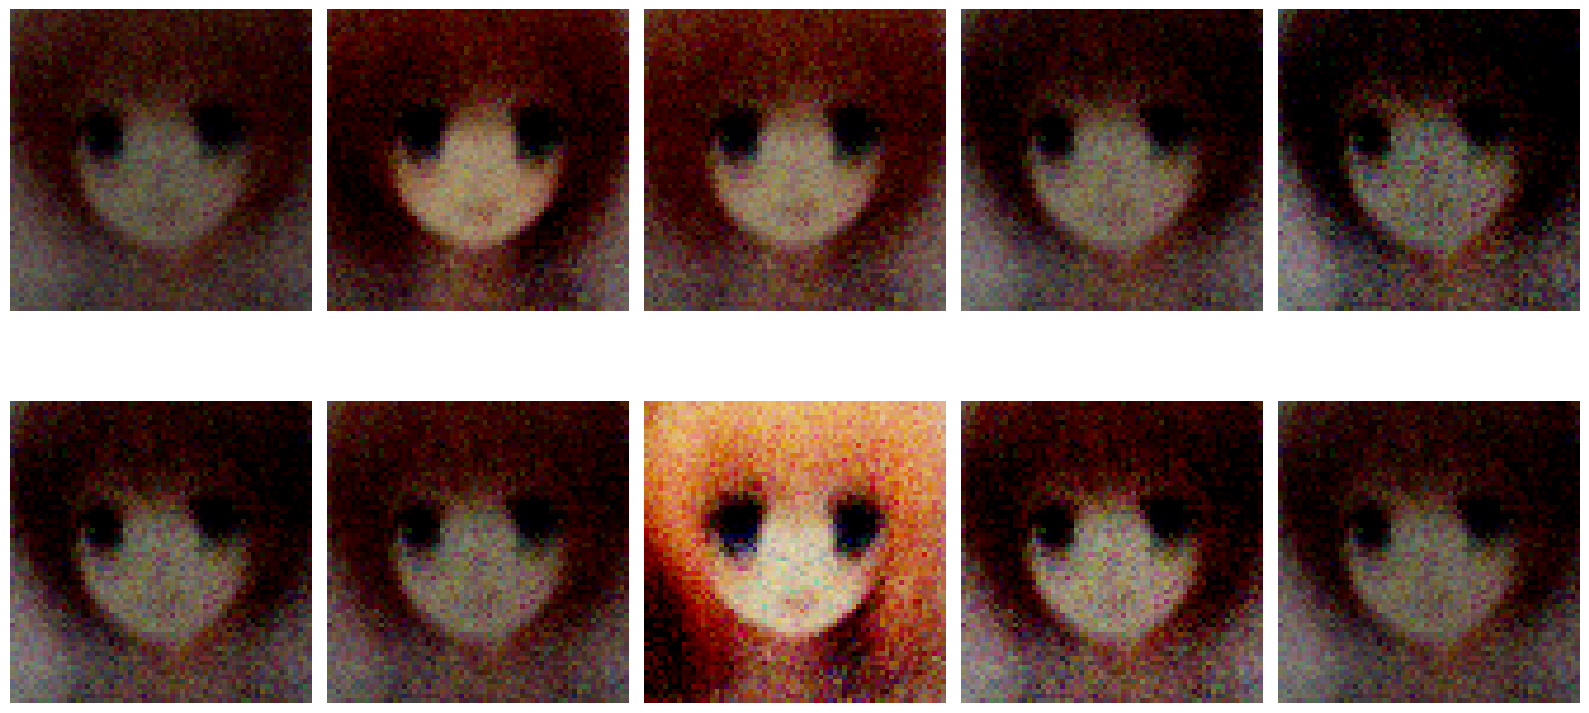

In [19]:
plt.figure(figsize=(16,9))
for x in range(5):
    for y in range(2):
        plt.subplot(2, 5, y * 5 + x + 1)
        plt.axis('off')
        plt.imshow(generated[y * 5 + x].permute(1,2,0).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

Получилось страшно и однообразно, можно попробовать задать другой z_dim

In [20]:
z_dim = 100
anime_dim = 3 * image_size * image_size

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(device)
D = Discriminator(anime_dim).to(device)


In [21]:
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [22]:
n_epoch = 50
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_dl):
        if len(x) != batch_size:
            continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/50]: loss_d: 0.840, loss_g: 1.200
[2/50]: loss_d: 0.639, loss_g: 1.520
[3/50]: loss_d: 0.562, loss_g: 1.643
[4/50]: loss_d: 0.525, loss_g: 1.677
[5/50]: loss_d: 0.882, loss_g: 2.446
[6/50]: loss_d: 0.814, loss_g: 2.410
[7/50]: loss_d: 0.888, loss_g: 1.613
[8/50]: loss_d: 0.774, loss_g: 2.727
[9/50]: loss_d: 0.870, loss_g: 1.465
[10/50]: loss_d: 1.264, loss_g: 2.033
[11/50]: loss_d: 0.596, loss_g: 2.014
[12/50]: loss_d: 2.273, loss_g: 1.768
[13/50]: loss_d: 1.318, loss_g: 1.532
[14/50]: loss_d: 1.370, loss_g: 5.468
[15/50]: loss_d: 1.449, loss_g: 2.398
[16/50]: loss_d: 1.222, loss_g: 3.522
[17/50]: loss_d: 0.811, loss_g: 5.140
[18/50]: loss_d: 0.815, loss_g: 2.446
[19/50]: loss_d: 0.790, loss_g: 2.511
[20/50]: loss_d: 0.823, loss_g: 1.944
[21/50]: loss_d: 0.645, loss_g: 3.130
[22/50]: loss_d: 0.867, loss_g: 2.485
[23/50]: loss_d: 0.675, loss_g: 2.040
[24/50]: loss_d: 0.542, loss_g: 1.781
[25/50]: loss_d: 0.709, loss_g: 1.971
[26/50]: loss_d: 0.829, loss_g: 2.304
[27/50]: loss_d: 0.72

In [23]:
test_z = torch.autograd.Variable(torch.randn(10, z_dim).to(device))
generated = G(test_z)
generated = generated.view(10, 3, 64, 64)
generated.shape

torch.Size([10, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

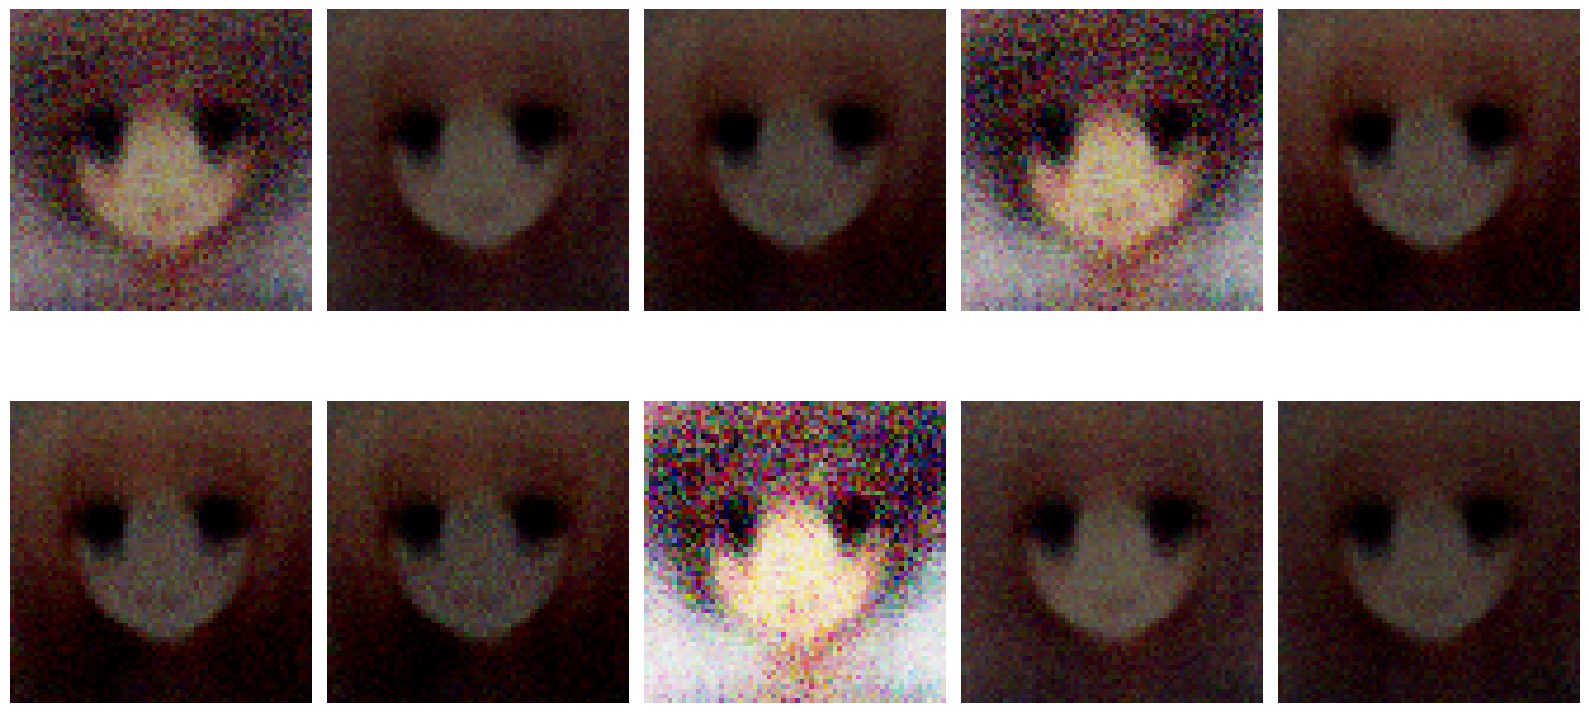

In [24]:
plt.figure(figsize=(16,9))
for x in range(5):
    for y in range(2):
        plt.subplot(2, 5, y * 5 + x + 1)
        plt.axis('off')
        plt.imshow(generated[y * 5 + x].permute(1,2,0).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

Стало хуже, видимо чем больше z_dim, тем лучше. Попробуем взять больше

In [25]:
z_dim = 4096
anime_dim = 3 * image_size * image_size

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(device)
D = Discriminator(anime_dim).to(device)
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [26]:
n_epoch = 100
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_dl):
        if len(x) != batch_size:
            continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/50]: loss_d: 0.850, loss_g: 1.183
[2/50]: loss_d: 0.610, loss_g: 1.403
[3/50]: loss_d: 0.573, loss_g: 1.746
[4/50]: loss_d: 0.433, loss_g: 1.849
[5/50]: loss_d: 0.491, loss_g: 3.386
[6/50]: loss_d: 0.453, loss_g: 3.006
[7/50]: loss_d: 0.865, loss_g: 2.464
[8/50]: loss_d: 0.459, loss_g: 3.793
[9/50]: loss_d: 0.674, loss_g: 3.731
[10/50]: loss_d: 0.896, loss_g: 5.358
[11/50]: loss_d: 1.262, loss_g: 3.001
[12/50]: loss_d: 0.933, loss_g: 5.350
[13/50]: loss_d: 0.684, loss_g: 9.529
[14/50]: loss_d: 1.347, loss_g: 8.477
[15/50]: loss_d: 1.306, loss_g: 5.231
[16/50]: loss_d: 1.060, loss_g: 3.980
[17/50]: loss_d: 0.955, loss_g: 3.501
[18/50]: loss_d: 0.976, loss_g: 3.160
[19/50]: loss_d: 1.049, loss_g: 3.096
[20/50]: loss_d: 1.336, loss_g: 3.089
[21/50]: loss_d: 0.956, loss_g: 2.311
[22/50]: loss_d: 0.879, loss_g: 2.462
[23/50]: loss_d: 1.251, loss_g: 3.939
[24/50]: loss_d: 1.303, loss_g: 2.600
[25/50]: loss_d: 0.751, loss_g: 3.228
[26/50]: loss_d: 0.690, loss_g: 2.843
[27/50]: loss_d: 0.84

In [27]:
test_z = torch.autograd.Variable(torch.randn(10, z_dim).to(device))
generated = G(test_z)
generated = generated.view(10, 3, 64, 64)
generated.shape

torch.Size([10, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

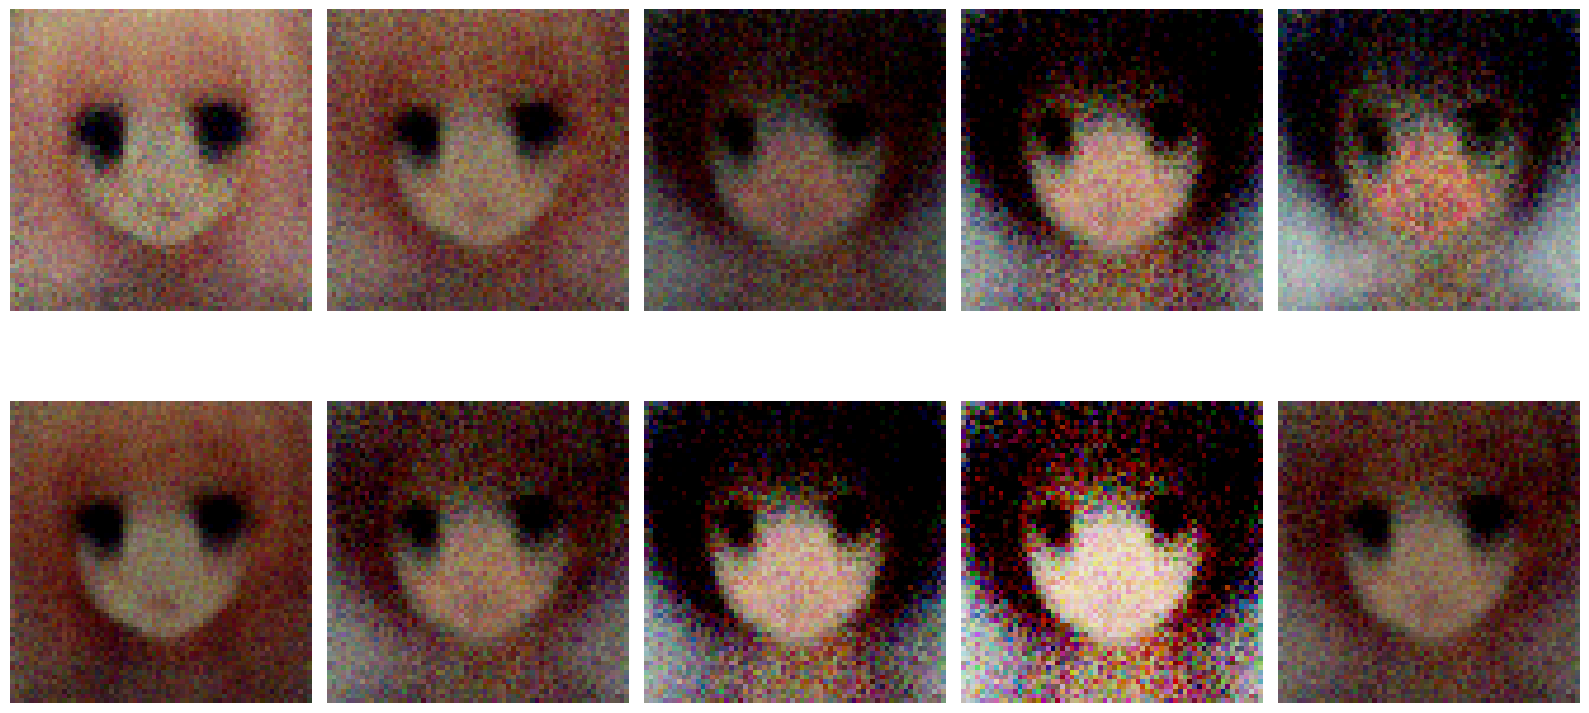

In [28]:
plt.figure(figsize=(16,9))
for x in range(5):
    for y in range(2):
        plt.subplot(2, 5, y * 5 + x + 1)
        plt.axis('off')
        plt.imshow(generated[y * 5 + x].permute(1,2,0).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()

z_dim = 500 всё таки давала лучший результат. Хотя может дело вовсе не в z_dim. Просто дискриминатор в один момент стал лучше генератора и не давал ему развиваться.
Хотя разнообразие картинок кажется улучшилось, виднеются как мужчины, так и женщины.
Напоследок попробуем z_dim = 500 и 200 эпох 

In [30]:
z_dim = 500
anime_dim = 3 * image_size * image_size

G = Generator(g_input_dim = z_dim, g_output_dim = anime_dim).to(device)
D = Discriminator(anime_dim).to(device)
# loss
criterion = nn.BCELoss() 

# optimizer
lr = 0.0002 
G_optimizer = torch.optim.Adam(G.parameters(), lr = lr)
D_optimizer = torch.optim.Adam(D.parameters(), lr = lr)

In [31]:
n_epoch = 200
for epoch in range(1, n_epoch+1):           
    D_losses, G_losses = [], []
    for batch_idx, (x, _) in enumerate(train_dl):
        if len(x) != batch_size:
            continue
        D_losses.append(D_train(x))
        G_losses.append(G_train(x))

    print('[%d/%d]: loss_d: %.3f, loss_g: %.3f' % (
            (epoch), n_epoch, torch.mean(torch.FloatTensor(D_losses)), torch.mean(torch.FloatTensor(G_losses))))

[1/200]: loss_d: 0.853, loss_g: 1.115
[2/200]: loss_d: 0.655, loss_g: 1.390
[3/200]: loss_d: 0.698, loss_g: 1.781
[4/200]: loss_d: 0.591, loss_g: 1.561
[5/200]: loss_d: 0.566, loss_g: 2.856
[6/200]: loss_d: 0.830, loss_g: 2.206
[7/200]: loss_d: 1.091, loss_g: 3.604
[8/200]: loss_d: 1.045, loss_g: 3.915
[9/200]: loss_d: 1.252, loss_g: 3.560
[10/200]: loss_d: 1.409, loss_g: 3.750
[11/200]: loss_d: 0.808, loss_g: 4.118
[12/200]: loss_d: 0.956, loss_g: 3.433
[13/200]: loss_d: 1.717, loss_g: 2.783
[14/200]: loss_d: 0.991, loss_g: 4.306
[15/200]: loss_d: 1.054, loss_g: 3.109
[16/200]: loss_d: 0.579, loss_g: 3.139
[17/200]: loss_d: 0.852, loss_g: 1.967
[18/200]: loss_d: 0.346, loss_g: 2.626
[19/200]: loss_d: 0.652, loss_g: 2.601
[20/200]: loss_d: 0.791, loss_g: 2.238
[21/200]: loss_d: 0.624, loss_g: 4.256
[22/200]: loss_d: 0.724, loss_g: 3.465
[23/200]: loss_d: 0.986, loss_g: 2.509
[24/200]: loss_d: 0.724, loss_g: 2.069
[25/200]: loss_d: 0.858, loss_g: 2.190
[26/200]: loss_d: 0.549, loss_g: 2

In [32]:
test_z = torch.autograd.Variable(torch.randn(10, z_dim).to(device))
generated = G(test_z)
generated = generated.view(10, 3, 64, 64)
generated.shape

torch.Size([10, 3, 64, 64])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

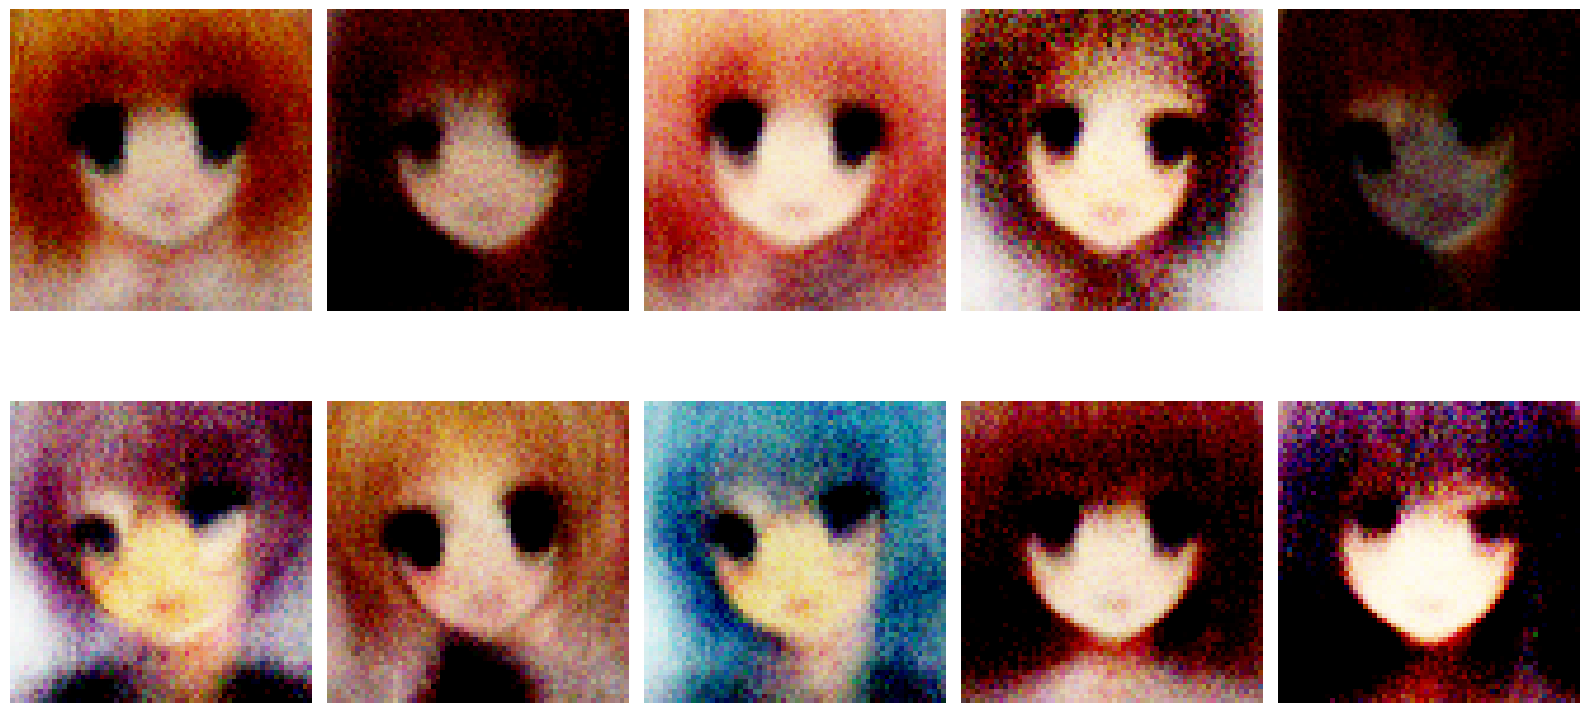

In [33]:
plt.figure(figsize=(16,9))
for x in range(5):
    for y in range(2):
        plt.subplot(2, 5, y * 5 + x + 1)
        plt.axis('off')
        plt.imshow(generated[y * 5 + x].permute(1,2,0).cpu().detach(), cmap='gray')
plt.tight_layout()
plt.show()